# 0. About Dataset


This dataset provides comprehensive prediction market data for the 2024 US Presidential Election, sourced from Polymarket, a leading blockchain-based prediction market platform. It offers a unique glimpse into real-time probabilistic forecasts for election outcomes across all 50 US states



## About Polymarket

Polymarket is a decentralized information markets platform that allows users to trade on the outcomes of events, effectively crowdsourcing predictions. For political events like the US Presidential Election, these markets can offer valuable insights into public sentiment and expectations.



## Data Structure

Each CSV file contains the following columns:

    Date (UTC): Timestamp of the prediction
    Republican: Probability of a Republican win
    Democrat: Probability of a Democratic win
    Other: Probability of any other outcome
    Potential Uses

This dataset is invaluable for political analysts, data scientists, and researchers interested in:

    Tracking the evolution of election predictions over time
    Comparing prediction market data with traditional polling methods
    Analyzing state-by-state variations in election forecasts
    Studying the impact of political events on prediction markets

## Limitations and Considerations

Prediction markets reflect the collective beliefs of traders, not necessarily the actual probabilities of outcomes.
The data starts at different times for different states and frequencies, which should be considered in analyses.
Polymarket data is subject to market dynamics and may be influenced by factors such as liquidity and trader behavior.


## Data Collection Method

The data was systematically collected from Polymarket using web scraping techniques, ensuring consistent and reliable extraction across all states and time periods.
This dataset offers a unique opportunity to dive deep into the dynamics of political prediction markets, providing insights into how perceptions of the 2024 US Presidential Election evolved over time across all 50 states. Whether you're interested in political forecasting, time series analysis, or studying the behavior of prediction markets, this comprehensive collection of Polymarket data serves as a valuable resource for your research and analysis.

# 1. Import Neccessary Libraries

In [1]:
#!pip3 install prophet

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
#from pmdarima import auto_arima

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# 2. Load Dataset

In [3]:
# Data load extract from Kaggle Data Source
df = pd.read_csv("AL_daily.csv")

df['Date (UTC)'] = pd.to_datetime(df['Date (UTC)'])
df.set_index('Date (UTC)', inplace=True)

df

,Timestamp (UTC),Donald Trump,Kamala Harris,Other
Date (UTC),,,,
2024-03-29 00:00:00,1711670402,0.9200,0.0750,0.0150
2024-03-30 00:00:00,1711756802,0.9200,0.0750,0.0090
2024-03-31 00:00:00,1711843203,0.9200,0.0750,0.0090
2024-04-01 00:00:00,1711929602,0.9150,0.0750,0.0090
2024-04-02 00:00:00,1712016003,0.9150,0.0750,0.0090
...,...,...,...,...
2024-11-01 00:00:00,1730419203,0.9865,0.0065,0.0025
2024-11-02 00:00:00,1730505603,0.9875,0.0055,0.0025
2024-11-03 00:00:00,1730592003,0.9870,0.0050,0.0025


# 3. EDA

In [4]:
print(df.describe())
print(df.info())


       Timestamp (UTC)  Donald Trump  Kamala Harris       Other
count     2.220000e+02    222.000000     222.000000  222.000000
mean      1.721217e+09      0.950313       0.034459    0.009079
std       5.548953e+06      0.027172       0.022451    0.004075
min       1.711670e+09      0.905000       0.004000    0.001500
25%       1.716444e+09      0.925000       0.017500    0.004500
50%       1.721218e+09      0.955000       0.023000    0.010500
75%       1.725991e+09      0.977500       0.055000    0.012500
max       1.730697e+09      0.989000       0.075000    0.017000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2024-03-29 00:00:00 to 2024-11-04 05:15:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp (UTC)  222 non-null    int64  
 1   Donald Trump     222 non-null    float64
 2   Kamala Harris    222 non-null    float64
 3   Other            222 non-null    float64
dtypes:

# Visualizing Probabilities Over Time

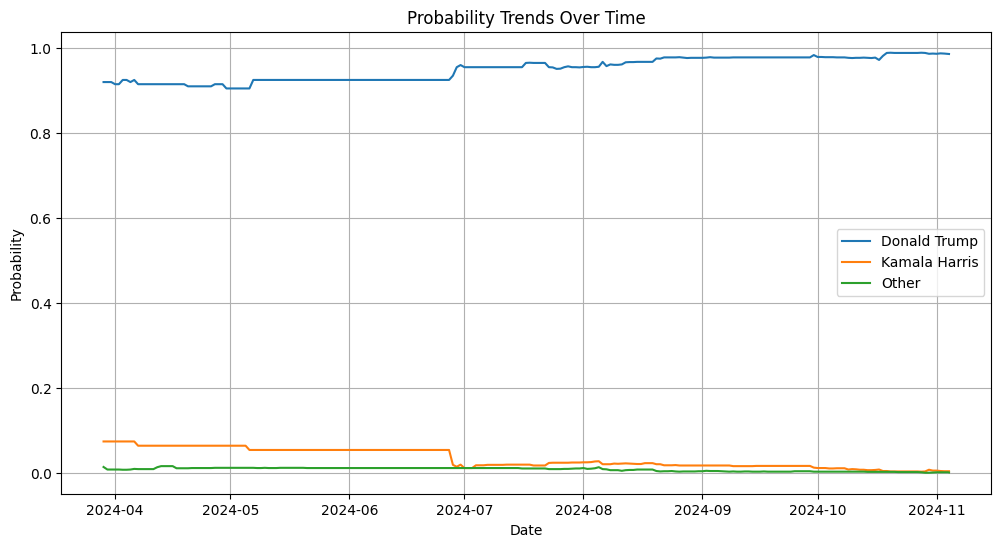

In [5]:
# Line plot to visualize probabilities over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date (UTC)', y='Donald Trump', label='Donald Trump')
sns.lineplot(data=df, x='Date (UTC)', y='Kamala Harris', label='Kamala Harris')
sns.lineplot(data=df, x='Date (UTC)', y='Other', label='Other')
plt.title('Probability Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


On July 21, 2024, however President Biden announced his withdrawal from the presidential race and endorsed his vice president Kamala Harris as the Democratic nominee.

# Plot the Trends

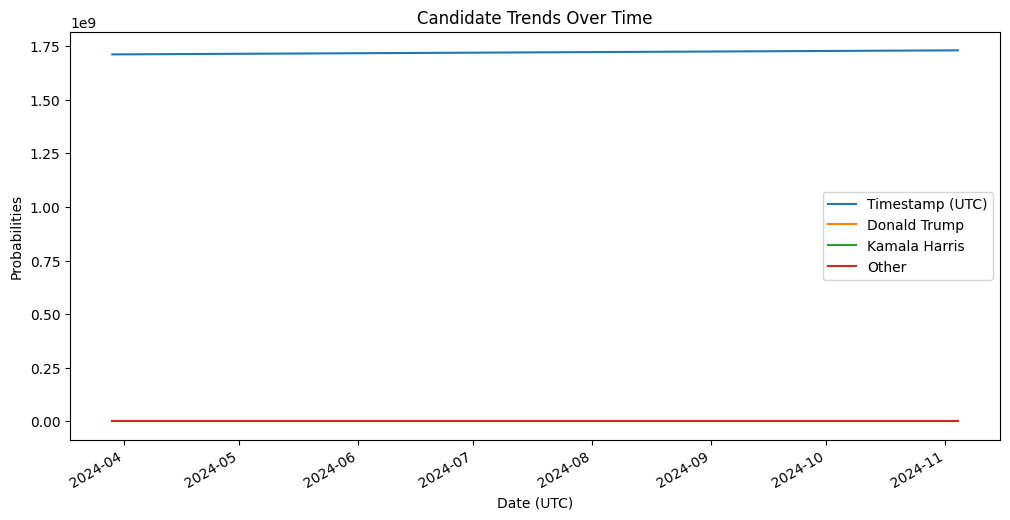

In [6]:
df.plot(figsize=(12, 6), title="Candidate Trends Over Time")
plt.ylabel("Probabilities")
plt.show()


# 4. Stationarity Check

In [7]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

check_stationarity(df['Donald Trump'])

ADF Statistic: -0.7186598795544519
p-value: 0.8418568245152684
Non-Stationary


# 5. Prophet Modelling

Prophet requires a specific column format (ds for dates and y for the variable to predict).

14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:07 - cmdstanpy - INFO - Chain [1] done processing


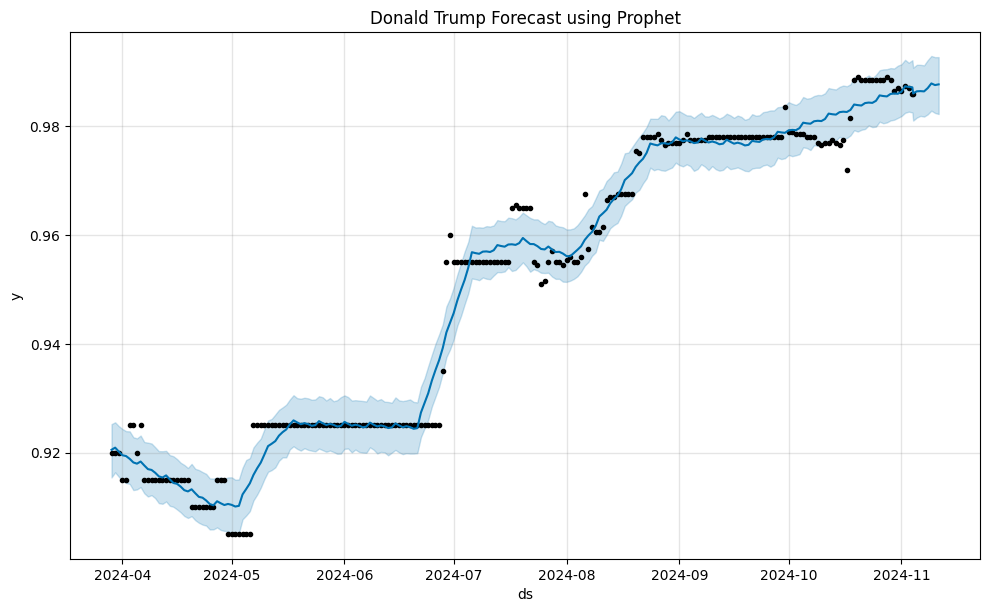

In [8]:
df_prophet = df.reset_index()[['Date (UTC)', 'Donald Trump']]
df_prophet.columns = ['ds', 'y']

# Initialize and Fit Prophet Model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Forecast into the Future
future = model_prophet.make_future_dataframe(periods=7)
forecast = model_prophet.predict(future)

# Plot Forecast
model_prophet.plot(forecast)
plt.title("Donald Trump Forecast using Prophet")
plt.show()


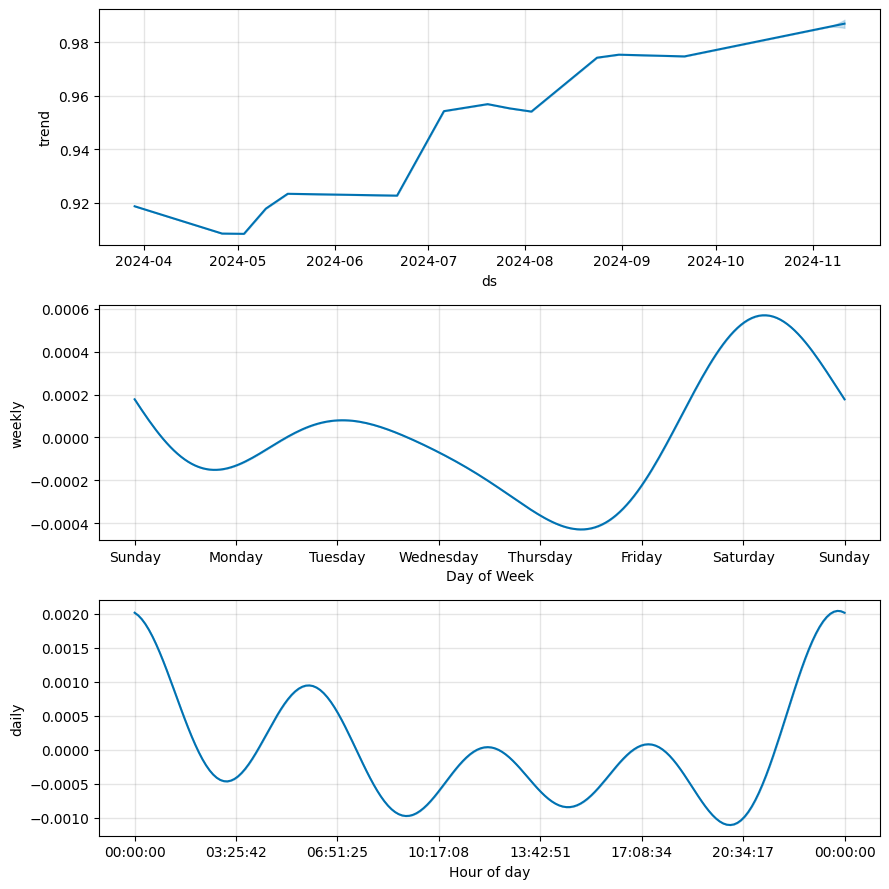

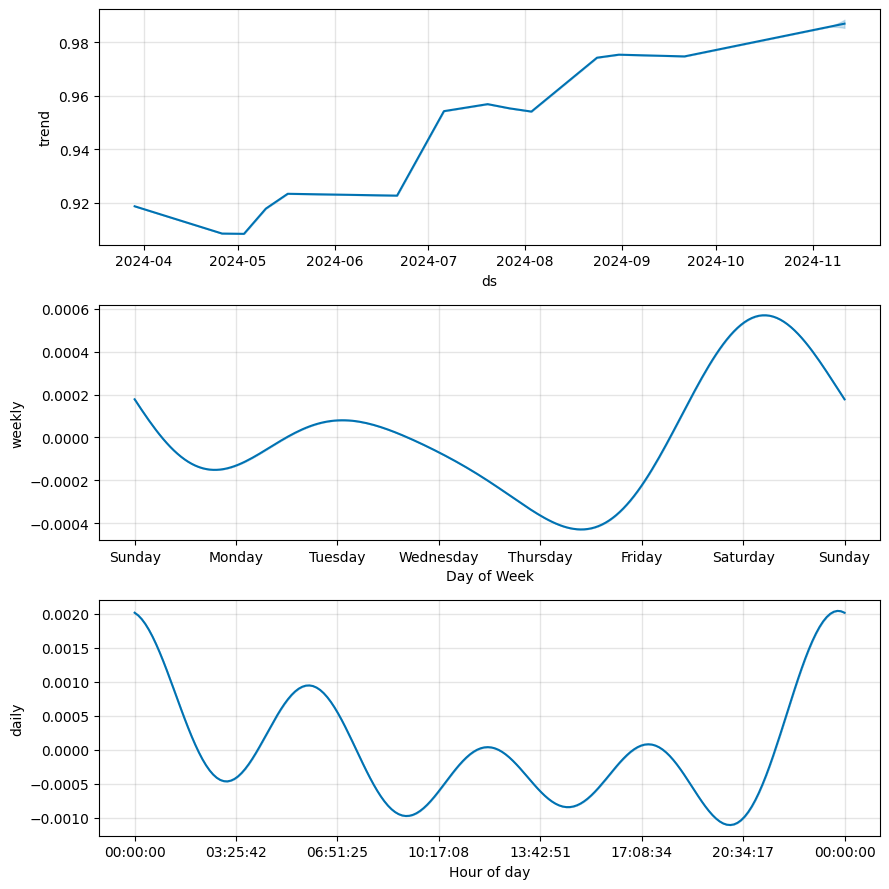

In [9]:
model_prophet.plot_components(forecast)


# 6. Combine Predictions for Multiple Candidates

14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:07 - cmdstanpy - INFO - Chain [1] done processing


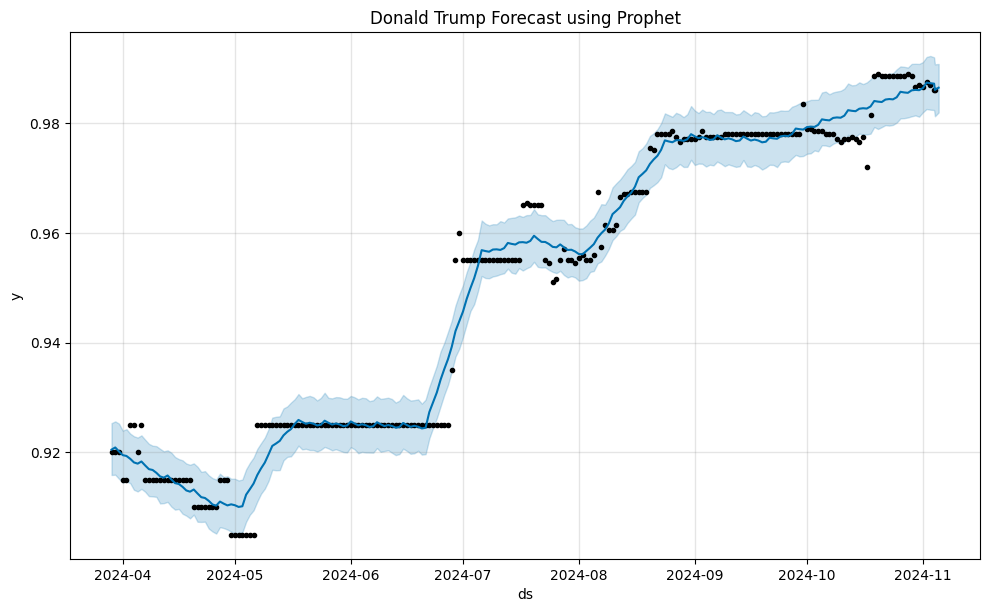

14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:07 - cmdstanpy - INFO - Chain [1] done processing


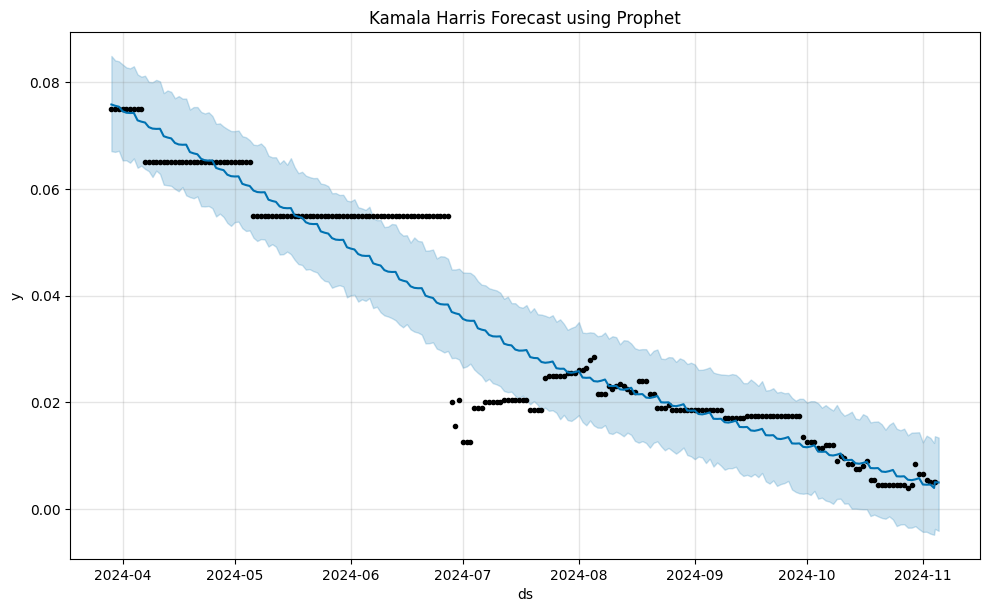

14:15:07 - cmdstanpy - INFO - Chain [1] start processing
14:15:07 - cmdstanpy - INFO - Chain [1] done processing


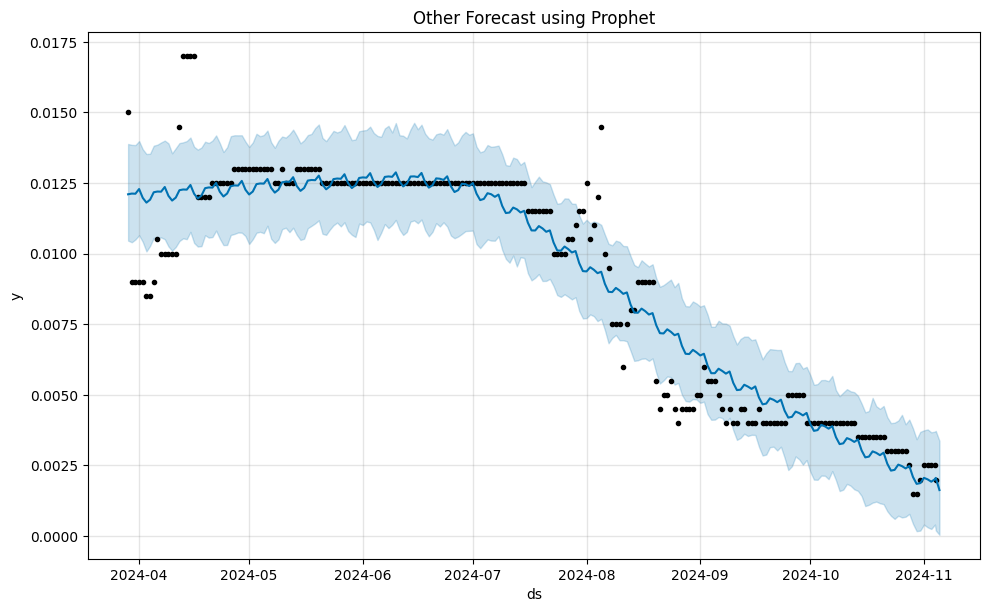

In [10]:
candidates = ['Donald Trump', 'Kamala Harris', 'Other']
forecasts = {}

for candidate in candidates:
    df_temp = df.reset_index()[['Date (UTC)', candidate]]
    df_temp.columns = ['ds', 'y']
    
    # Prophet model
    model = Prophet()
    model.fit(df_temp)
    future = model.make_future_dataframe(periods=1)
    forecasts[candidate] = model.predict(future)
    
    # Plot Forecast
    model.plot(forecasts[candidate])
    plt.title(f"{candidate} Forecast using Prophet")
    plt.show()


# 7. Determine the Winner

Combine forecasts for each candidate and determine the winner based on the highest probability:

In [11]:
future_predictions = pd.DataFrame({
    'Date': future['ds'],
    'Donald Trump': forecasts['Donald Trump']['yhat'],
    'Kamala Harris': forecasts['Kamala Harris']['yhat'],
    'Other': forecasts['Other']['yhat'],
})

future_predictions['Winner'] = future_predictions[['Donald Trump', 'Kamala Harris', 'Other']].idxmax(axis=1)
print(future_predictions)


                   Date  Donald Trump  Kamala Harris     Other        Winner
0   2024-03-29 00:00:00      0.920509       0.075827  0.012101  Donald Trump
1   2024-03-30 00:00:00      0.920902       0.075588  0.012126  Donald Trump
2   2024-03-31 00:00:00      0.920182       0.075419  0.012121  Donald Trump
3   2024-04-01 00:00:00      0.919508       0.074563  0.012287  Donald Trump
4   2024-04-02 00:00:00      0.919354       0.074285  0.011974  Donald Trump
..                  ...           ...            ...       ...           ...
218 2024-11-02 00:00:00      0.987357       0.004562  0.002005  Donald Trump
219 2024-11-03 00:00:00      0.987241       0.004597  0.001923  Donald Trump
220 2024-11-04 00:00:00      0.987171       0.003946  0.002011  Donald Trump
221 2024-11-04 05:15:00      0.986041       0.005029  0.002057  Donald Trump
222 2024-11-05 05:15:00      0.986432       0.004978  0.001626  Donald Trump

[223 rows x 5 columns]
